In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

from src import pygt_loader

from src import chickenpox
from src.chickenpox import ChickenpoxDatasetLoader
import json

ModuleNotFoundError: No module named 'torch_geometric_temporal'

In [149]:
# SET TO CPU
DEVICE = torch.device('cpu') # cuda
shuffle=True
batch_size = 32

In [150]:
dataset_path = "data/graphs/chickenpox.json"

dataset_json = json.load(open(dataset_path))
# test['edges']


In [151]:
loader = ChickenpoxDatasetLoader(dataset_json)

In [152]:
import json
import os
print(os.getcwd())
# Load JSON data



dataset = loader.get_dataset(lags=4)
# loader = pygt_loader.DataLoader('data/graphs/chickenpox.json', num_, batch_size=3, shuffle=True)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset[0])))
print(next(iter(dataset))) # Show first sample

c:\Users\raphc\OneDrive\Personal Projects\EVE Online Quant\EVE Markets\EVE code\forecasting
Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x000002584F864D60>
Number of samples / sequences:  4
Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])


nodes = counties in hungary

node features = lagged weekly count of chickenpox cases (they include 4 lags)

edges = neighbourhoods

target = weekly number of cases for the upcoming week (signed integers)

Data includes 517 snapshots

In [153]:
county = 1

weekly_cases = [bucket.y[county] for bucket in list(dataset)]

In [154]:
print(dataset[0].x.shape)

torch.Size([20, 4])


In [155]:
print(dataset[0].x[0])

tensor([-0.0011,  0.0286,  0.3547,  0.2954])


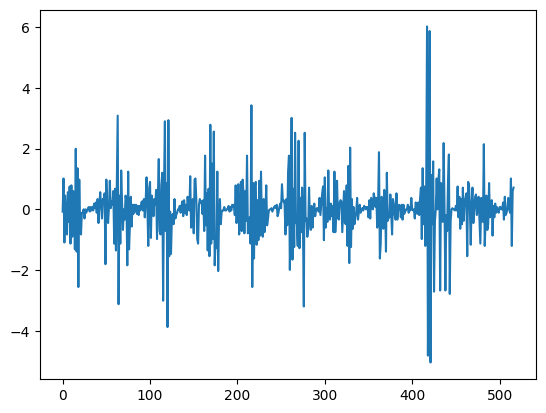

In [156]:
plt.plot(weekly_cases)


In [157]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(train_dataset)))
# print("Number of test buckets: ", len(set(test_dataset)))

In [158]:
print(dataset[0].x[0])

tensor([-0.0011,  0.0286,  0.3547,  0.2954])


In [159]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [160]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h



In [161]:
# Create model and optimizers
model = TemporalGNN(node_features=1, periods=4, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([4])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 1])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([4, 32])
linear.bias 	 torch.Size([4])
Net's total params: 6568
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 

In [162]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    # break

In [163]:
for snapshot in static_edge_index:
    print(snapshot)

tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
        13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
        17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19])
tensor([10,  6, 13,  1,  0,  5, 16,  0, 16,  1, 14, 10,  8,  2,  5,  8, 15, 12,
         9, 10,  3,  4, 13,  0, 10,  2,  5,  0, 16,  6, 14, 13, 11, 18,  7, 17,
        11, 18,  3,  2, 15,  8, 10,  9, 13,  3, 12, 10,  5,  9,  8,  3, 10,  2,
        13,  0,  6, 11,  7, 13, 18,  3,  9, 13, 12, 13,  9,  6,  4, 12,  0, 11,
        10, 18, 19,  1, 14,  6, 16,  3, 15,  8, 16, 14,  1,  0,  6,  7, 19, 17,
        18, 14, 18, 17,  7,  6, 19, 11, 18, 14, 19, 17])


In [167]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        # encoder_inputs = encoder_inputs.unsqueeze(0)  # Add an extra dimension to match the expected input shape
        # print(encoder_inputs)
        print(labels[0][county])
        y_hat = model(encoder_inputs, static_edge_index[county])         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

tensor(-1.1620)


IndexError: too many indices for tensor of dimension 2